# Feature Selection 
## Import Libraries 

In [53]:
import pandas as pd
import numpy as np
import os
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Stratified Sampling

In [21]:
def take_sample(df, sampling_ratio):
    application_sample1 = df.loc[df.TARGET==1].sample(sampling_ratio=sampling_ratio, replace=False)
    print('label 1 sample size:', str(application_sample1.shape[0]))
    application_sample0 = df.loc[df.TARGET==0].sample(sampling_ratio=sampling_ratio, replace=False)
    print('label 0 sample size:', str(application_sample0.shape[0]))
    return pd.concat([application_sample1, application_sample0], axis=0).sort_values('SK_ID_CURR')

### Set folder paths for getting input and saving outputs

In [22]:
def setupFolderPaths():    
    #Set input data folder 
    dataFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'ProjectDataFiles'
    if(not os.path.exists(dataFolder)):
        print("Input Data folder not found. Please specify data folder path as dataFolder variable to proceed")
        raise NotADirectoryError

    #Create output folder is it does not exist
    outputFolder = os.getcwd() + os.sep + os.pardir + os.sep + 'CodeOutputs'

    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
        print('Output Folder created')
        
    return dataFolder, outputFolder

In [15]:
def readFile(fileName):
    if(not os.path.exists(fileName)):
        raise FileNotFoundError
        
    return pd.read_csv(fileName)

In [7]:
#Function to replace outliers in input data
def replace_outliers(df):
    #Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    if 'CODE_GENDER' in df:
        df = df[df['CODE_GENDER'] != 'XNA']

    #Replace outlier values with nan
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].map(lambda x: x if x <= 0 else np.nan)
    df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].map(lambda x: x if x >= 0 else np.nan)
    df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL'].map(lambda x: x if x <= 1e8 else np.nan)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].map(lambda x: x if x <= 10 else np.nan)
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 40 else np.nan)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 50 else np.nan)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].map(lambda x: x if x <= 100 else np.nan)
    
    return df

In [8]:
#Function to identify feature types in a given data frame
def identify_feature_types(df, features_to_ignore):
    categorical_features = list(f for f in df.select_dtypes(include='object') if f not in features_to_ignore)
    floatingPoint_features = list(f for f in df.select_dtypes(include='float64') if f not in features_to_ignore)
    temp = list(f for f in df.select_dtypes(include='int64') if f not in features_to_ignore)
    bool_features = [x for x in temp if 'FLAG' in x]
    integer_features = [x for x in temp if x not in bool_features]
    totalCount = len(categorical_features) + len(floatingPoint_features) + len(bool_features) + len(integer_features)
    print ('Catagorical Features : {}, Floating Point Features : {}, Boolean Features : {}, Integer Features : {}, Total Count : {}'
       .format(len(categorical_features), len(floatingPoint_features), len(bool_features), len(integer_features), totalCount))
    
    return categorical_features, floatingPoint_features, bool_features, integer_features

In [17]:
def scale_features(df, feature_list, scale_range = (0,1)):
    #Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = scale_range)
    
    for feature in feature_list:
        scaler.fit(df[feature].values.reshape(-1,1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1,1))
    
    return df

In [18]:
def impute_features(df, feature_list, imputeMode = 'median'):
    #Imputer for numerical features
    imputer = Imputer(strategy = imputeMode)
    
    for feature in feature_list:
        imputer.fit(df[feature].values.reshape(-1,1))
        df[feature] = imputer.transform(df[feature].values.reshape(-1,1))

    return df

In [11]:
dataFolder, outputFolder = setupFolderPaths()

In [94]:
# Read Training data
input_df = readFile(dataFolder + '\\application_train.csv')
input_df = replace_outliers(input_df)
categorical_feats, floatingPoint_feats, bool_feats, integer_feats = identify_feature_types(input_df,
                                                                                        ['TARGET', 'SK_ID_CURR', 'Unnamed :0'])
for cat_feature in categorical_feats:
    input_df[cat_feature] = input_df[cat_feature].fillna(input_df[cat_feature].value_counts().index[0])
    
input_df = impute_features(input_df, integer_feats + floatingPoint_feats)
#input_df = scale_features(input_df, integer_feats + floatingPoint_feats)
    
input_df = pd.get_dummies(input_df, columns=categorical_feats, dtype=np.int64)

Catagorical Features : 16, Floating Point Features : 66, Boolean Features : 26, Integer Features : 12, Total Count : 120


In [95]:
labels = input_df.pop('TARGET')
input_df_ids = input_df.pop('SK_ID_CURR')

In [28]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 243 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: float64(78), int64(165)
memory usage: 572.4 MB


# <a id='2'>Feature Selection</a>
- select **100** features from 226
- **xxx_support**: list to represent select this feature or not
- **xxx_feature**: the name of selected features

## <a id='2-1'>1 Filter</a>
- documentation for **SelectKBest**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

###  <a id='2-1-1'>1.1 Pearson Correlation</a>
**Note**
- Normalization: no
- Impute missing values: yes

In [31]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-10:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in X.columns]
    return cor_support, cor_feature

In [32]:
cor_support, cor_feature = cor_selector(input_df, labels)
print(str(len(cor_feature)), 'selected features')

150 selected features


###  <a id='2-1-2'>1.2 Chi-2</a>

**Note**
- Normalization: MinMaxScaler (values should be bigger than 0)
- Impute missing values: yes

In [35]:
input_df = scale_features(input_df, integer_feats + floatingPoint_feats)
chi_selector = SelectKBest(chi2, k=150)
chi_selector.fit(input_df, labels)

SelectKBest(k=150, score_func=<function chi2 at 0x000001AB835C0730>)

In [37]:
chi_support = chi_selector.get_support()
chi_feature = input_df.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

150 selected features


## <a id='2-2'>2. Wrapper</a>
- documentation for **RFE**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

**Note**
- Normalization: depend on the used model; yes for LR
- Impute missing values: depend on the used model; yes for LR


In [41]:
rfe_selector = RFE(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_features_to_select=150, step=10, verbose=15)
rfe_selector.fit(input_df, labels)

Fitting estimator with 243 features.
Fitting estimator with 233 features.
Fitting estimator with 223 features.
Fitting estimator with 213 features.
Fitting estimator with 203 features.
Fitting estimator with 193 features.
Fitting estimator with 183 features.
Fitting estimator with 173 features.
Fitting estimator with 163 features.
Fitting estimator with 153 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=150, step=10, verbose=15)

In [43]:
rfe_support = rfe_selector.get_support()
rfe_feature = input_df.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
#predicted = rfe_selector.predict()

150 selected features


TypeError: predict() missing 1 required positional argument: 'X'

## <a id='2-3'>3. Embeded</a>
- documentation for **SelectFromModel**: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
###  <a id='2-3-1'>3.1 Logistics Regression L1</a>
**Note**
- Normalization: Yes
- Impute missing values: Yes

In [46]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(input_df, labels)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='1.25*median')

In [47]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = input_df.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

105 selected features


###  <a id='2-3-2'>3.2 Random Forest</a>
**Note**
- Normalization: No
- Impute missing values: Yes

In [87]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=150), threshold='1.25*median')
embeded_rf_selector.fit(input_df, labels)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold='1.25*median')

In [88]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = input_df.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

105 selected features


###  <a id='2-3-3'>3.3 LightGBM</a>
**Note**
- Normalization: No
- Impute missing values: No

In [79]:
var_selector = VarianceThreshold(0.01)
var_selector.fit_transform(input_df)

array([[0.0000000e+00, 2.0250000e+05, 4.0659750e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.7000000e+05, 1.2935025e+06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.7500000e+04, 1.3500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.5300000e+05, 6.7766400e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.7100000e+05, 3.7010700e+05, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.5750000e+05, 6.7500000e+05, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [80]:
var_support = var_selector.get_support()
var_feature = input_df.loc[:,var_support].columns.tolist()
print(str(len(var_feature)), 'selected features')

117 selected features


# <a id='3'>Summary</a>

In [97]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':input_df.columns, 'Variance': var_support, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 
                                     'Random Forest':embeded_rf_support})
## count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
top100 = feature_selection_df.head(100).Feature.values

In [104]:
#input_df = input_df[top100]
#len(labels)
#input_df['TARGET'] = labels
input_df.to_csv(outputFolder + '\\DataSetVersion6_a.csv')

In [19]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

In [17]:
# Code for cross validation
def cross_validation(X, Y):
    num_fold = 10
    skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=2018)
    valid_scores = []
    train_scores = []
    
    for train_index, test_index in skf.split(X, Y):
        X_train, X_validation = X.iloc[train_index], X.iloc[test_index]
        y_train, y_validation = Y.iloc[train_index], Y.iloc[test_index]
        
        clf = LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=31,
            feature_fraction=0.8,
            subsample=0.8,
            max_depth=8,
            reg_alpha=1,
            reg_lambda=1,
            min_child_weight=40,
            random_state=2018,
            nthread=-1
            )
                   
        clf.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_validation, y_validation)], 
                eval_metric='auc',
                verbose = False,
                early_stopping_rounds=100
                )
        
        train_prediction = clf.predict_proba(X_train)[:, 1]
        train_score = roc_auc_score(y_train, train_prediction)
        train_scores.append(train_score)
        
        valid_prediction = clf.predict_proba(X_validation)[:, 1]
        valid_score = roc_auc_score(y_validation, valid_prediction)
        valid_scores.append(valid_score)
        
        print('Fold', num_fold, train_score, valid_score, clf.best_iteration_)
        num_fold = num_fold - 1
        
    print('AUC mean:', np.mean(valid_scores), 'std:',np.std(valid_scores))


In [35]:
cross_validation(X, y)

Fold 10 0.812634480439176 0.7681582099890205 188
Fold 9 0.8269712224312014 0.7709758274623234 271
Fold 8 0.8322233769383449 0.7692052525733071 301
Fold 7 0.8276940696885526 0.7703268172347967 278
Fold 6 0.8215941993985365 0.7638644209804539 238
Fold 5 0.8094169752403899 0.7677882423179452 170
Fold 4 0.8194007178561147 0.7728549903439474 228
Fold 3 0.8323629945990998 0.7805441716085262 311
Fold 2 0.8405524744543277 0.7667364925582206 357
Fold 1 0.8101481054335824 0.7657218715946266 176
AUC mean: 0.7696176296663169 std: 0.004409550794988882


In [32]:

# #############################################################################
# Classification and ROC analysis

def cross_validation_LR(train, train_labels):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)
    log_reg = LogisticRegression(C = 0.001, n_jobs = -1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for trainSet, testSet in cv.split(train, train_labels):
        probas_ = log_reg.fit(train.iloc[trainSet], train_labels.iloc[trainSet]).predict_proba(train.iloc[testSet])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(train_labels.iloc[testSet], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
                 #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        print(i)
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
#print(FS_df.head())
#y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

0
1
2
3
4
5
6
7
8
9


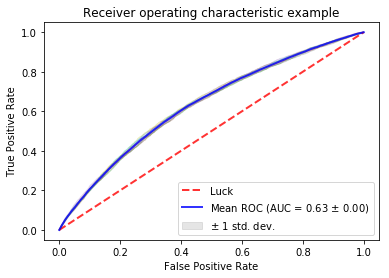

In [34]:
cross_validation_LR(X, y)